<a href="https://colab.research.google.com/github/Sadickachuli/Classification-ML/blob/main/Fish_Analysis_Classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 style=" text-align:center; color:Blue; font-size:40px; display: block;"> <u><b><i>About The Dataset</i></b></u> </h2>


<p><b>This dataset contains 9 different seafood types collected from a supermarket in Izmir, Turkey
for a university-industry collaboration project at Izmir University of Economics, and this work
was published in ASYU 2020.
The dataset includes gilt head bream, red sea bream, sea bass, red mullet, horse mackerel,
black sea sprat, striped red mullet, trout, shrimp image samples.</b></p>

<h2 style=" text-align:center; color:Blue; font-size:40px; display: block;"> <u><b><i>Objective</i></b></u> </h2>
<p><b> Efficient classification of images with Tf/Keras.</b></p>

In [7]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'a-large-scale-fish-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1165452%2F2170465%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240819%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240819T130315Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D35390440c16dd0b33d7f7be76a9d38c9a3c88af8f4a6bddb9d3b756d506eab1e24bcf7dfdbcc79c1c1b8fed5692d90eec1100baa422358bdc832c929b082f4ac3c7c9935aed54d9e8a56623321f142fd1d06fdc3a3c79a11ef94a7701b3a11a6494faf08aaae5d20dbd8b425ac5eec053af0fc49fe795217e983189344bbe90985e9bc4c0f2227154d779d919a8aead2743b11bc45e677a0162a98bedcc345d822f28f6f429a8e88dcf7c0e7185b4e8a59aa1a6b4e5ebfa26148b008be144c8d15f8fd2e51c448316e9b74df78ccef44cfa5c4c1388f983fa53e6cc9e285ca01df428cd95318a1f8c50087e448ebf704058211ba76458ed5a8fb959a34ed3cec'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3482438117 bytes downloaded
Downloaded and uncompressed: a-large-scale-fish-dataset
Data source import complete.


## 1. Importing The Modules

In [8]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf


## 2. Loading The Data

In [9]:
direc = Path('../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset')
filepaths = list(direc.glob(r'**/*.png'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))



filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
Labels = pd.Series(Labels, name='Labels').astype(str)


img_df = pd.merge(filepaths, Labels, right_index = True, left_index = True)

img_df = img_df[ img_df['Labels'].apply(lambda x: x[-2:]!='GT') ]

#Resampling it
img_df=img_df.sample(frac = 1).reset_index(drop=True)
img_df.head()

,FilePaths,Labels
0,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
1,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Mullet
2,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream
3,../input/a-large-scale-fish-dataset/Fish_Datas...,Gilt-Head Bream
4,../input/a-large-scale-fish-dataset/Fish_Datas...,Gilt-Head Bream


### 2.1 Displaying First 9 Images

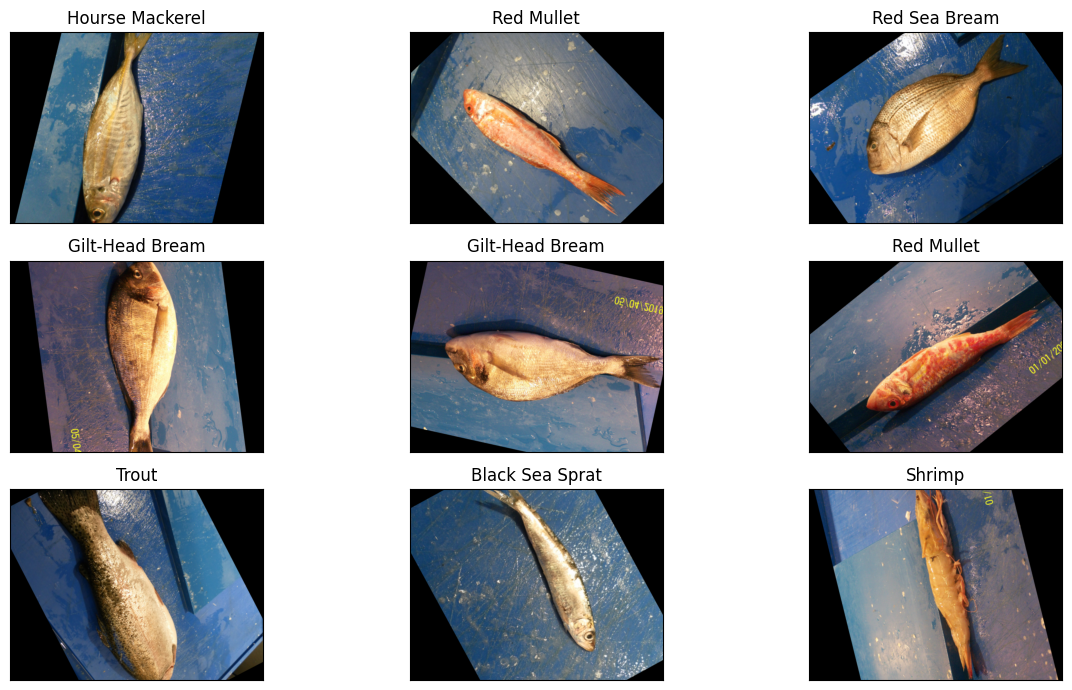

In [10]:
# Showing 9Images
import matplotlib.pyplot as plt
f,a = plt.subplots(nrows=3, ncols=3,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(img_df.FilePaths[i]))
    ax.set_title(img_df.Labels[i])

plt.tight_layout()
plt.show()


### 2.2 Shape Of DataFrame

In [11]:
print(f" Count of Rows : {img_df.shape[0]} \n Count of Columns : {img_df.shape[1]} ")

 Count of Rows : 9000 
 Count of Columns : 2 


### 2.3 Types Of Fishes

In [12]:
img_df['Labels'].value_counts(ascending=True)

,count
Labels,
Hourse Mackerel,1000
Red Mullet,1000
Red Sea Bream,1000
Gilt-Head Bream,1000
Trout,1000
Black Sea Sprat,1000
Shrimp,1000
Sea Bass,1000
Striped Red Mullet,1000


## 3. Splitting The Data

In [13]:
train_ratio = 0.75
validation_ratio = 0.10
test_ratio = 0.15


x_train, x_test = train_test_split(img_df, test_size=1 - train_ratio)
x_val, x_test = train_test_split(x_test, test_size=test_ratio/(test_ratio + validation_ratio))

print(f'Shape of Training Data : ',x_train.shape)
print(f'Shape of Testing Data : ',x_test.shape)
print(f'Shape of Validation Data : ',x_val.shape)
x_testt = x_test.copy()


Shape of Training Data :  (6750, 2)
Shape of Testing Data :  (1350, 2)
Shape of Validation Data :  (900, 2)


### 3.1 Augmenating The Data

In [14]:
img_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

img_size=(224, 224)

x_train = img_datagen.flow_from_dataframe(dataframe = x_train, x_col='FilePaths', y_col='Labels', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)
x_test = img_datagen.flow_from_dataframe(dataframe = x_test, x_col='FilePaths', y_col='Labels', target_size=img_size,color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)
x_val = img_datagen.flow_from_dataframe(dataframe = x_val, x_col='FilePaths', y_col='Labels', target_size=img_size, color_mode='rgb',class_mode='categorical',batch_size=32,seed=42)

Found 6750 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


> 1. Scaling input pixels to (-1,1).


## 3.2 Creating The Model

In [22]:
import tensorflow as tf

# Define the model with the correct input shape
fc_model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(9, activation="softmax")  # 9 classes for classification
])

# Compile the model
fc_model.compile(optimizer="adam",
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])

# Fit the model
Callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
mo_fit = fc_model.fit(x_train,
                      validation_data=x_val,
                      epochs=10,
                      callbacks=[Callback])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


211/211 ━━━━━━━━━━━━━━━━━━━━ 166s 759ms/step - accuracy: 0.3407 - loss: 1.7915 - val_accuracy: 0.6356 - val_loss: 1.0468
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 183s 671ms/step - accuracy: 0.6572 - loss: 0.9929 - val_accuracy: 0.7267 - val_loss: 0.7661
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 154s 718ms/step - accuracy: 0.7545 - loss: 0.7075 - val_accuracy: 0.8178 - val_loss: 0.5311
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 199s 703ms/step - accuracy: 0.8317 - loss: 0.4923 - val_accuracy: 0.8444 - val_loss: 0.4325
Epoch 5/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 201s 698ms/step - accuracy: 0.8690 - loss: 0.3823 - val_accuracy: 0.8989 - val_loss: 0.3248
Epoch 6/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 166s 776ms/step - accuracy: 0.9059 - loss: 0.2779 - val_accuracy: 0.8867 - val_loss: 0.3032
Epoch 7/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 147s 682ms/step - accuracy: 0.9258 - loss: 0.2212 - val_accuracy: 0.8922 - val_loss: 0.3298
Epoch 8/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 200s 679ms/step - accuracy: 0.9345 - loss: 0.18

## 3.3 Training The Model

In [24]:
print('Model summary :')
print()
fc_model.summary()


Model summary :



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │      19,267,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,856,157 (220.70 MB)

 Trainable params: 19,285,385 (73.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,570,772 (147.14 MB)

In [25]:
test_accuracy = fc_model.evaluate(x_test)[1] * 100
print('Test accuracy is : ',test_accuracy, '%' )


43/43 ━━━━━━━━━━━━━━━━━━━━ 22s 516ms/step - accuracy: 0.9380 - loss: 0.1860
Test accuracy is :  93.92592310905457 %


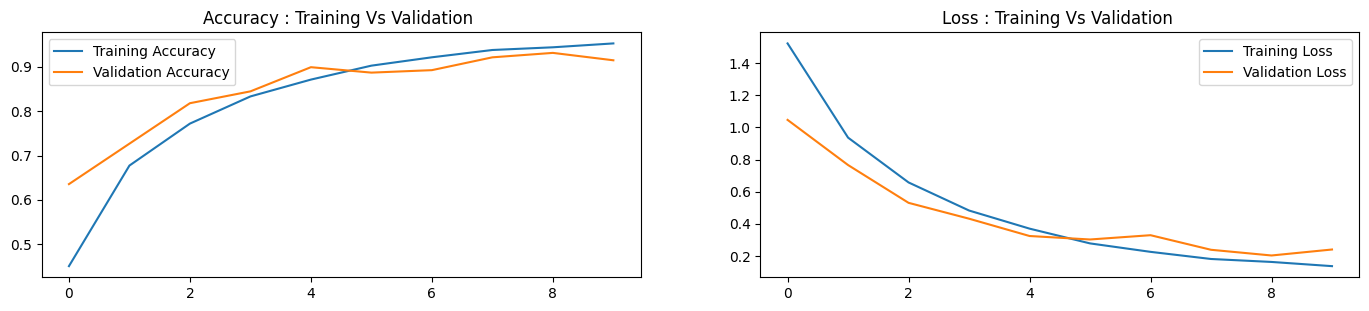

In [26]:
accuracy = mo_fit.history['accuracy']
loss = mo_fit.history['loss']
validation_loss = mo_fit.history['val_loss']
validation_accuracy = mo_fit.history['val_accuracy']



plt.figure(figsize=(17, 7))
plt.subplot(2, 2, 1)
plt.plot(range(10), accuracy, label='Training Accuracy')
plt.plot(range(10), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Accuracy : Training Vs Validation ')



plt.subplot(2, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), validation_loss, label='Validation Loss')
plt.title('Loss : Training Vs Validation ')
plt.legend(loc='upper right')
plt.show()

In [29]:
# Save the model
fc_model.save('fish_classifier_model.keras')

# To load the model later
loaded_model = tf.keras.models.load_model('fish_classifier_model.keras')

# After loading the model, recompile it with the same optimizer, loss, and metrics
loaded_model.compile(optimizer="adam",
                     loss="categorical_crossentropy",
                     metrics=["accuracy"])

# Now you can evaluate the model on test data
test_accuracy = loaded_model.evaluate(x_test)[1] * 100
print('Test accuracy is : ', test_accuracy, '%')


43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 518ms/step - accuracy: 0.9353 - loss: 0.1885
Test accuracy is :  93.92592310905457 %
